In [21]:
# Import Packages
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from pathlib import Path

In [22]:
# Import Data
tickers = ['BTC-USD', 'SPY', 'GLD', 'DX-Y.NYB']
df = yf.download(tickers, auto_adjust=True, progress=False)['Close']

# Create returns
ret = df.apply(lambda s: np.log(s).diff()).dropna() * 100
ret = ret.loc['2014-10-01':'2025-04-30']

# print(df.head())
# print(ret.head())
# print(ret.tail())

# Compute summary statistics of log return
summary_stats = ret.describe()

# Add median, kewness & kurtosis
summary_stats.loc["median"] = ret.median()
summary_stats.loc["skew"] = ret.skew()
summary_stats.loc["kurtosis"] = ret.kurtosis()

print(summary_stats)

Ticker        BTC-USD     DX-Y.NYB          GLD          SPY
count     2080.000000  2080.000000  2080.000000  2080.000000
mean         0.104562     0.003120     0.047192     0.054990
std          3.911362     0.450649     0.900569     1.126075
min        -46.473018    -2.398774    -5.518973   -10.056885
25%         -1.452032    -0.257096    -0.458653    -0.380833
50%          0.130766     0.009583     0.053617     0.059620
75%          1.844907     0.261875     0.524423     0.597781
max         22.511895     2.032029     4.787391     9.986280
median       0.130766     0.009583     0.053617     0.059620
skew        -0.973467    -0.197059    -0.082041    -0.077341
kurtosis    13.665292     1.893499     2.728933    11.613915


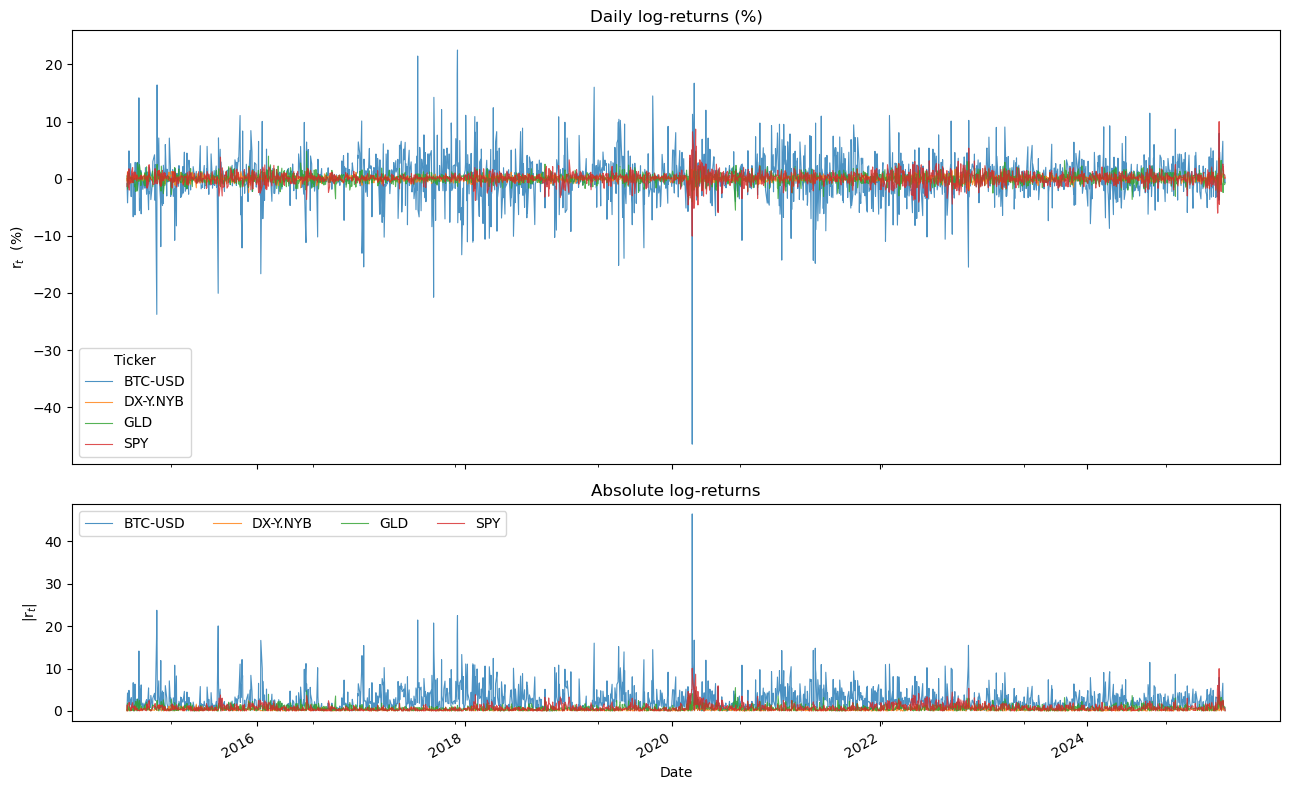

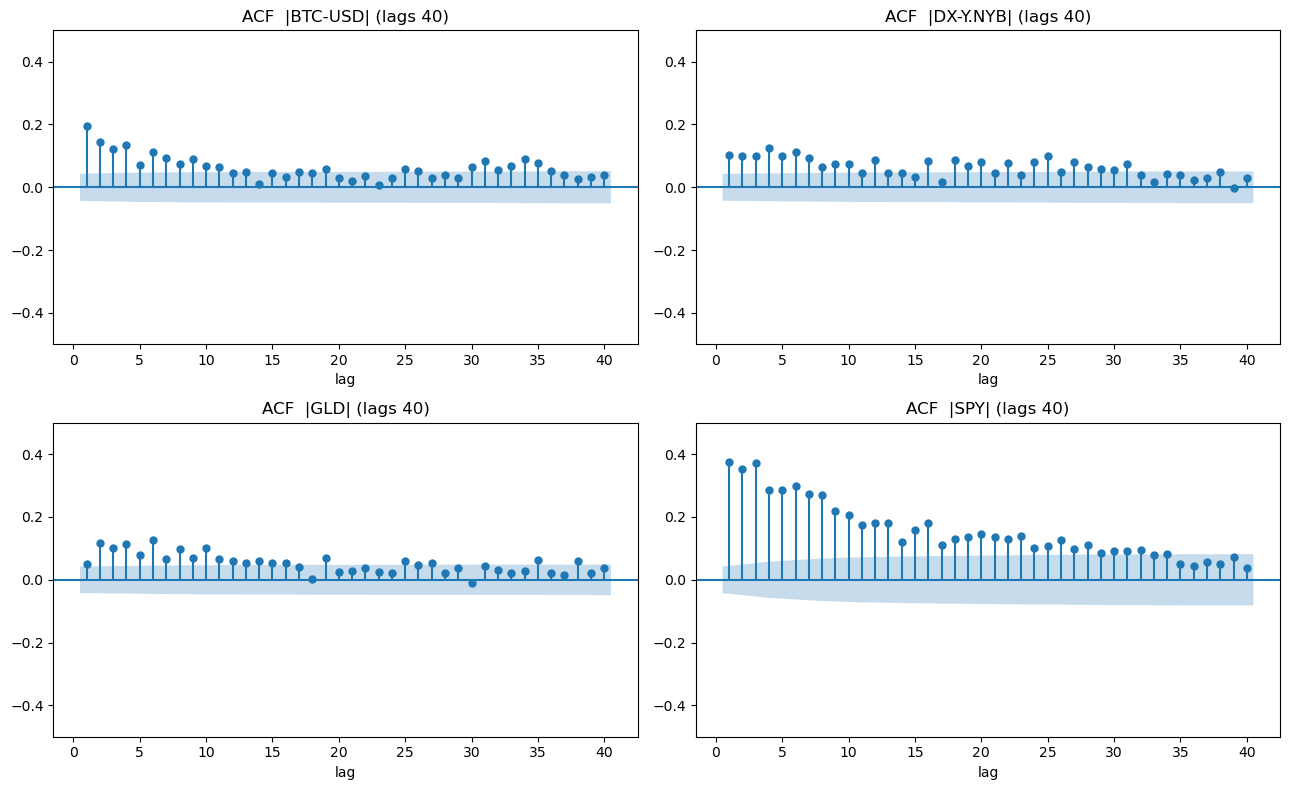

In [23]:
# Returns plot
cols = ret.columns.sort_values()

fig, ax = plt.subplots(2, 1, figsize=(13, 8), sharex=True,
                       gridspec_kw={'height_ratios': [2, 1]})

ret.plot(ax=ax[0], lw=0.8, alpha=.8)
ax[0].set(title='Daily log-returns (%)', ylabel='r$_t$  (%)')

# Absolute returns plot
ret.abs().plot(ax=ax[1], lw=0.8, alpha=.8)
ax[1].set(title='Absolute log-returns', ylabel='|r$_t$|')
ax[1].legend(loc='upper left', ncol=4)
plt.tight_layout()
plt.show()

# Autocorrelation plot
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes = axes.flatten()

for i, col in enumerate(cols):
    plot_acf(ret[col].abs(), lags=40, zero=False,
             ax=axes[i], title=f'ACF  |{col}| (lags 40)')
    axes[i].set_xlabel('lag')
    axes[i].set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

In [24]:
# Mean returns estimation on lagged returns
x = ret[['BTC-USD', 'DX-Y.NYB', 'GLD', 'SPY']].shift(1).dropna()
y = ret['BTC-USD'].loc[x.index]

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                BTC-USD   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.853
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.116
Time:                        13:26:34   Log-Likelihood:                -5781.8
No. Observations:                2079   AIC:                         1.157e+04
Df Residuals:                    2074   BIC:                         1.160e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1102      0.086      1.281      0.2

In [25]:
# Compute GARCH(1,1)
garch = arch_model(ret["BTC-USD"],
                     mean='AR', lags=1,
                     vol='Garch', p=1, q=1,
                     dist='t')
garch_res = garch.fit(disp='off')
print("\n=== GARCH(1,1) summary ===")
print(garch_res.summary())

# Compute GJR-GARCH(1,1)
gjr_garch = arch_model(ret["BTC-USD"],
                   mean='AR', lags=1,
                   vol='GARCH', p=1, o=1, q=1,     
                   power=2.0,                      
                   dist='t')
gjr_res = gjr_garch.fit(disp='off')
print("\n=== GJR-GARCH(1,1) summary ===")
print(gjr_res.summary())

# Export summaries
ols_txt = model.summary().as_text()
garch_txt = garch_res.summary().as_text()
gjr_garch_txt = gjr_res.summary().as_text()

with open(out_dir / "mean_equation_summary.txt", "w") as f:
    f.write(ols_txt)
with open(out_dir / "garch_summary.txt", "w") as f:
    f.write(garch_txt)
with open(out_dir / "gjr_garch_summary.txt", "w") as f:
    f.write(gjr_garch_txt)


=== GARCH(1,1) summary ===
                              AR - GARCH Model Results                              
Dep. Variable:                      BTC-USD   R-squared:                       0.003
Mean Model:                              AR   Adj. R-squared:                  0.002
Vol Model:                            GARCH   Log-Likelihood:               -5384.85
Distribution:      Standardized Student's t   AIC:                           10781.7
Method:                  Maximum Likelihood   BIC:                           10815.5
                                              No. Observations:                 2079
Date:                      Sat, May 24 2025   Df Residuals:                     2077
Time:                              13:26:35   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------


Simple Correlation
Ticker    BTC-USD  DX-Y.NYB    GLD    SPY
Ticker                                   
BTC-USD     1.000    -0.085  0.098  0.245
DX-Y.NYB   -0.085     1.000 -0.468 -0.108
GLD         0.098    -0.468  1.000  0.070
SPY         0.245    -0.108  0.070  1.000


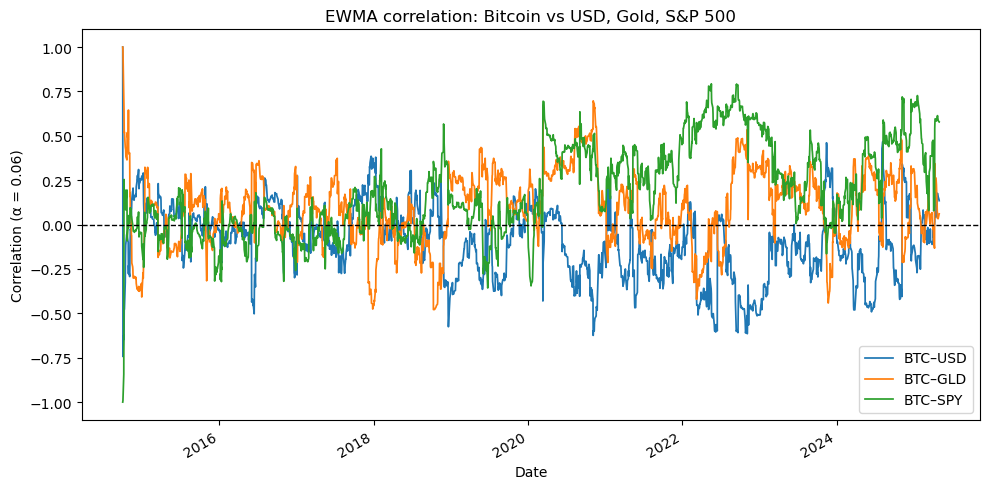

In [26]:
# Calculate correlation matrix
corr = ret.corr()

# Calculate EMA correlation matrix
alpha = 0.06
ema_mean = ret.ewm(alpha=alpha, adjust=False).mean()
ema_var = (ret ** 2).ewm(alpha=alpha, adjust=False).mean()
ema_std = np.sqrt(ema_var)
ema_cov = ret.ewm(alpha=alpha, adjust=False).cov(pairwise=True)
ema_corr = ret.ewm(alpha=alpha, adjust=False).corr(pairwise=True)

# print(ema_mean.head())
# print(ema_var.head())
# print(ema_std.head())
# print(ema_cov.head(10))
# print(ema_corr.head(10))

# Compare simple correlation vs. rolling correlation matrices
print("\nSimple Correlation")
print(corr.round(3))

corr_wide = (
    ema_corr
      .stack()                # Series with 3-level index: Date, row-asset, col-asset
      .rename('corr')
      .unstack(level=2)       # last level → columns, still multi-indexed rows
      .swaplevel(0, 1, axis=0)
      .unstack(level=0)       # flatten completely: Date as index, pair as cols
)
corr_wide.columns = [f'{i}|{j}' for i, j in corr_wide.columns]

cols_to_plot = ['BTC-USD|DX-Y.NYB', 'BTC-USD|GLD', 'BTC-USD|SPY']
corr_wide[cols_to_plot].plot(figsize=(10, 5), lw=1.25)
plt.title('EWMA correlation: Bitcoin vs USD, Gold, S&P 500')
plt.axhline(0, color='black', ls="--", lw=1,)
plt.ylabel('Correlation (α = 0.06)')
plt.legend(['BTC–USD', 'BTC–GLD', 'BTC–SPY'])
plt.tight_layout()
plt.show()

In [27]:
# 30-day rolling volatility of Bitcoin (annualized)
vol_window = 30
btc_vol = ret['BTC-USD'].rolling(vol_window).std() * np.sqrt(252)

# Assign a sign to volatility to rank them
signed_vol = np.sign(ret['BTC-USD']) * btc_vol

# Define 3 regimes by 20-80 quantiles
low_thr  = signed_vol.quantile(0.20)   
high_thr = signed_vol.quantile(0.80)   

neg_mask  = signed_vol <=  low_thr         
pos_mask  = signed_vol >=  high_thr        
mid_mask  = ~(neg_mask | pos_mask)      

# Function to calculate conditional correlations
def regime_corr(mask, name):
    sub = ret.loc[mask, ['BTC-USD', 'DX-Y.NYB', 'GLD', 'SPY']]
    row = sub.corr().iloc[0, 1:]     
    row.name = name
    return row

corr_df = pd.concat([
    regime_corr(neg_mask, 'Extreme-NEG vol'),
    regime_corr(mid_mask, 'Stagnation'),
    regime_corr(pos_mask, 'Extreme-POS vol')
], axis=1).T     

print('\nConditional BTC correlations')
print(corr_df.round(3))


Conditional BTC correlations
Ticker           DX-Y.NYB    GLD    SPY
Extreme-NEG vol    -0.045  0.117  0.351
Stagnation         -0.110  0.108  0.252
Extreme-POS vol     0.044 -0.034  0.091
